In [1]:
# Environment setup and imports
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import yaml
from typing import List, Dict

ROOT = Path().resolve().parents[2]  # project root
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.real_data import CriteoDataset, SyntheticCriteoDataset, PCBDataset
from src.models.esmm import ESMM
from src.models.gbdt_proto import MTGBDT
from src.models.stgbdt import STGBDTBaseline
from src.models.utils import add_cvr_labels


def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Compute CTR/CTCVR/CVR AUC and LogLoss."""
    eps = 1e-8
    y_click = y_true[:, 0]
    y_conv = y_true[:, 1]
    y_ctcvr = y_click * y_conv

    pred_ctr = np.clip(y_pred[:, 0], eps, 1 - eps)
    pred_ctcvr = np.clip(y_pred[:, 1], eps, 1 - eps)
    pred_cvr = np.clip(y_pred[:, 2], eps, 1 - eps)

    metrics = {}
    metrics["auc_ctr"] = roc_auc_score(y_click, pred_ctr)
    metrics["logloss_ctr"] = log_loss(y_click, pred_ctr)
    precision, recall, thresholds = precision_recall_curve(y_click, pred_ctr)
    metrics["pr_auc_ctr"] = auc(recall, precision)

    metrics["auc_ctcvr"] = roc_auc_score(y_ctcvr, pred_ctcvr)
    metrics["logloss_ctcvr"] = log_loss(y_ctcvr, pred_ctcvr)
    precision, recall, thresholds = precision_recall_curve(y_ctcvr, pred_ctcvr)
    metrics["pr_auc_ctcvr"] = auc(recall, precision)

    click_mask = y_click == 1
    if np.sum(click_mask) > 1 and np.unique(y_conv[click_mask]).size > 1:
        metrics["auc_cvr"] = roc_auc_score(y_conv[click_mask], pred_cvr[click_mask])
        metrics["logloss_cvr"] = log_loss(y_conv[click_mask], pred_cvr[click_mask])
        precision, recall, thresholds = precision_recall_curve(y_conv[click_mask], pred_cvr[click_mask])
        metrics["pr_auc_cvr"] = auc(recall, precision)
    else:
        metrics["auc_cvr"] = np.nan
        metrics["logloss_cvr"] = np.nan
    return metrics

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# Configure paths and parameter
def get_data(train_size: int, test_size: int, val_size: int, data_type: str):
    sample_size = train_size + test_size + val_size
    seed = 42
    output_csv = ROOT / "reports" / "tables" / "criteo_experiment_notebook.csv"
    results = []

    if data_type == "criteo":
        # Load Criteo or Synthetic dataset
        data_path = ROOT / "src" / "data" / "criteo-research-uplift-v2.1.csv.gz"
        dataset = CriteoDataset(sample_size=sample_size)
        try:
            X, y = dataset.get_data(random_state=seed)
            source = "CriteoDataset"
        except Exception:
            synth = SyntheticCriteoDataset(sample_size=sample_size)
            X, y = synth.load_data(random_state=seed)
            source = "SyntheticCriteoDataset"

    elif data_type == "PCB":
        # Load Criteo or Synthetic dataset
        data_path = ROOT / "src" / "data" / "pcb_dataset_final.tsv.zip"
        dataset = PCBDataset(sample_size=sample_size)
        X, y = dataset.get_data(random_state=seed)
        source = "PCBDataset"

    print(f"Using dataset from {source} with {X.shape[0]} samples and {X.shape[1]} features.")
    # Random permutation without overlap
    rng = np.random.default_rng(seed)
    perm = rng.permutation(X.shape[0])
    if len(perm) < sample_size:
        raise ValueError(f"Requested {sample_size} samples but only {len(perm)} available")

    train_idx = perm[:train_size]
    val_idx = perm[train_size:train_size + val_size]
    test_idx = perm[train_size + val_size:train_size + val_size + test_size]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [3]:
train_size=100000
val_size=30000
test_size=100000

X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size, data_type="PCB")
results = []

Loading PCB dataset from CSV sample: C:\Users\oiwal\products\MT_AI_GBDT\src\data\pcb_dataset_final.tsv_sample500000.csv


array([[ 0.72450482,  0.9856608 ,  0.97121881, ..., -0.66801111,
        -1.39922414,  0.70532332],
       [ 0.21905562,  1.35067674, -1.27789021, ..., -0.87062898,
         0.46590564, -0.32526026],
       [ 1.15767025, -1.4140116 ,  1.34674882, ..., -0.55118398,
         0.46590564,  0.74659224],
       ...,
       [ 0.99071921, -0.37109157, -1.54855799, ...,  1.03135722,
         0.88946027,  0.70532332],
       [ 0.51845727,  1.23100417,  1.30254955, ...,  1.68564652,
         0.46590564, -1.90572702],
       [ 0.77864304,  0.19841342,  1.44576513, ..., -0.01648863,
        -2.58567762,  0.74659224]], shape=(100000, 20))

In [4]:
def do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results):
    # ESMM
    esmm = ESMM(epochs=5, batch_size=256, verbose=0, validation_split=0.0)
    esmm.fit(X_train, y_train)
    esmm_pred = esmm.predict_proba(X_test)
    esmm_metrics = evaluate_predictions(y_test, esmm_pred)
    esmm_metrics.update({"model": "ESMM", "train_size": train_size})
    esmm_metrics
    results.append(esmm_metrics)

def do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="mtgbm"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "mtgbm", "train_size": train_size})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="ctcvr_subctr_de_norm_gain"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": f"propose_{delta}", "train_size": train_size})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="propose_kai"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "propose_kai", "n_estimators": mtgbdt.n_estimators})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results):
    # STGBDT
    stg = STGBDTBaseline(
        n_estimators=20, learning_rate=0.1, max_depth=3, min_samples_split=20, min_samples_leaf=10
    )
    stg.fit(X_train, y_train)
    stg_pred = stg.predict_proba(X_test)
    stg_metrics = evaluate_predictions(y_test, stg_pred)
    stg_metrics.update({"model": "STGBDTBaseline", "train_size": train_size})
    stg_metrics
    results.append(stg_metrics)

def do_propose_half(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="half"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "propose_half", "n_estimators": mtgbdt.n_estimators})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

In [5]:
results = []
for train_size in [10000, 50000, 100000]:
    val_size=int(train_size * 0.5)
    test_size=100000
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size, data_type="PCB")
    do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results)
    do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.5)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=1)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=5)
    # do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=10)
    do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results)
    do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results)

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.358172, Time: 0.44s
Iteration 10/20, LogLoss: 0.295647, Time: 4.75s
Iteration 20/20, LogLoss: 0.263817, Time: 9.42s
Iteration 1/20, LogLoss: 0.358172, Time: 0.76s
Iteration 10/20, LogLoss: 0.271273, Time: 7.83s
Iteration 20/20, LogLoss: 0.245317, Time: 15.46s
Iteration 1/20, LogLoss: 0.358172, Time: 0.75s
Iteration 10/20, LogLoss: 0.271273, Time: 7.49s
Iteration 20/20, LogLoss: 0.245317, Time: 15.14s
Iteration 1/20, LogLoss: 0.639257, Time: 0.46s
Iteration 10/20, LogLoss: 0.587435, Time: 4.70s
Iteration 20/20, LogLoss: 0.571605, Time: 9.37s
Iteration 1/20, LogLoss: 0.100556, Time: 0.22s
Iteration 10/20, LogLoss: 0.032022, Time: 2.30s
Iteration 20/20, LogLoss: 0.011132, Time: 4.57s
Iteration 1/20, LogLoss: 0.293589, Time: 0.09s
Iteration 10/20, LogLoss: 0.087418, Time: 0.93s
Iteration 20/20, LogLoss: 0.029985, Time: 1.82s


c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


Iteration 1/20, LogLoss: 0.362701, Time: 4.99s
Iteration 10/20, LogLoss: 0.296692, Time: 45.50s
Iteration 20/20, LogLoss: 0.261722, Time: 86.79s
Iteration 1/20, LogLoss: 0.362701, Time: 6.95s
Iteration 10/20, LogLoss: 0.272502, Time: 69.34s
Iteration 20/20, LogLoss: 0.245989, Time: 136.69s
Iteration 1/20, LogLoss: 0.362701, Time: 7.01s
Iteration 10/20, LogLoss: 0.272502, Time: 70.99s
Iteration 20/20, LogLoss: 0.245989, Time: 143.29s
Iteration 1/20, LogLoss: 0.639449, Time: 4.20s
Iteration 10/20, LogLoss: 0.586395, Time: 43.97s
Iteration 20/20, LogLoss: 0.568919, Time: 87.50s
Iteration 1/20, LogLoss: 0.107000, Time: 2.11s
Iteration 10/20, LogLoss: 0.033748, Time: 22.60s
Iteration 20/20, LogLoss: 0.011716, Time: 45.82s
Iteration 1/20, LogLoss: 0.304866, Time: 0.91s
Iteration 10/20, LogLoss: 0.090994, Time: 9.60s
Iteration 20/20, LogLoss: 0.031206, Time: 19.00s


c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,pCTCVR_AUC,pCTCVR_accuracy,pCTCVR_loss,pCTR_AUC,pCTR_accuracy,pCTR_loss
  current = self.get_monitor_value(logs)


KeyboardInterrupt: 

In [9]:
for train_size in [10000, 50000]:
    val_size=int(train_size * 0.5)
    test_size=100000
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size)
    do_propose_half(X_train, X_val, X_test, y_train, y_val, y_test, results)

Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 115000 samples with 16 columns
Data shape: X=(115000, 12), y=(115000, 2)
Iteration 1/20, LogLoss: 0.063840, Time: 0.21s
Iteration 10/20, LogLoss: 0.049750, Time: 2.04s
Iteration 20/20, LogLoss: 0.046199, Time: 4.02s
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 175000 samples with 16 columns
Data shape: X=(175000, 12), y=(175000, 2)
Iteration 1/20, LogLoss: 0.061754, Time: 0.97s
Iteration 10/20, LogLoss: 0.049574, Time: 9.67s
Iteration 20/20, LogLoss: 0.046667, Time: 25.68s


In [6]:
# Aggregate and display metrics
headers = ["model", "auc_ctr", "auc_ctcvr", "auc_cvr", "logloss_ctr", "logloss_ctcvr", "logloss_cvr"]
print("\n=== Experiment Results ===")
for res in results:
    row = {h: res.get(h, np.nan) for h in headers}
    print(row)

df_results = pd.DataFrame(results)
df_results


=== Experiment Results ===
{'model': 'ESMM', 'auc_ctr': 0.6112418744394643, 'auc_ctcvr': 0.999746952269789, 'auc_cvr': 0.9999992917650479, 'logloss_ctr': 1.7289811625740044, 'logloss_ctcvr': 0.008592338437478784, 'logloss_cvr': 0.019603921896972305}
{'model': 'mtgbm', 'auc_ctr': 0.7120878888629715, 'auc_ctcvr': 0.9997977034187902, 'auc_cvr': 0.9997198143836852, 'logloss_ctr': 0.5733202769958118, 'logloss_ctcvr': 0.02555722106911653, 'logloss_cvr': 0.07643681777108396}
{'model': 'propose_0.01', 'auc_ctr': 0.7374146738869474, 'auc_ctcvr': 0.9994990238648678, 'auc_cvr': 0.9997389760737774, 'logloss_ctr': 0.5599726860619505, 'logloss_ctcvr': 0.011391019790616954, 'logloss_cvr': 0.030638259683172415}
{'model': 'propose_kai', 'auc_ctr': 0.7374146738869474, 'auc_ctcvr': 0.9994990238648678, 'auc_cvr': 0.9997389760737774, 'logloss_ctr': 0.5599726860619505, 'logloss_ctcvr': 0.011391019790616954, 'logloss_cvr': 0.030638259683172415}
{'model': 'STGBDTBaseline', 'auc_ctr': 0.7120681120130515, 'auc

,auc_ctr,logloss_ctr,pr_auc_ctr,auc_ctcvr,logloss_ctcvr,pr_auc_ctcvr,auc_cvr,logloss_cvr,pr_auc_cvr,model,train_size,n_estimators
0,0.611242,1.728981,0.549146,0.999747,0.008592,0.999343,0.999999,0.019604,0.999995,ESMM,10000.0,NaN
1,0.712088,0.573320,0.656375,0.999798,0.025557,0.999560,0.999720,0.076437,0.999612,mtgbm,10000.0,NaN
2,0.737415,0.559973,0.658242,0.999499,0.011391,0.999421,0.999739,0.030638,0.999739,propose_0.01,10000.0,NaN
3,0.737415,0.559973,0.658242,0.999499,0.011391,0.999421,0.999739,0.030638,0.999739,propose_kai,NaN,20.0
4,0.712068,0.573405,0.656419,0.999691,0.011391,0.999706,0.999691,0.030638,0.999733,STGBDTBaseline,10000.0,NaN
5,0.626789,1.669881,0.561913,1.000000,0.000346,1.000000,1.000000,0.000531,1.000000,ESMM,50000.0,NaN
6,0.716668,0.571154,0.656233,1.000000,0.023961,1.000000,1.000000,0.069774,1.000000,mtgbm,50000.0,NaN
7,0.735937,0.560880,0.657570,1.000000,0.011600,1.000000,1.000000,0.030948,1.000000,propose_0.01,50000.0,NaN
8,0.735937,0.560880,0.657570,1.000000,0.011600,1.000000,1.000000,0.030948,1.000000,propose_kai,NaN,20.0
9,0.716668,0.571154,0.656233,1.000000,0.011600,1.000000,1.000000,0.030948,1.000000,STGBDTBaseline,50000.0,NaN


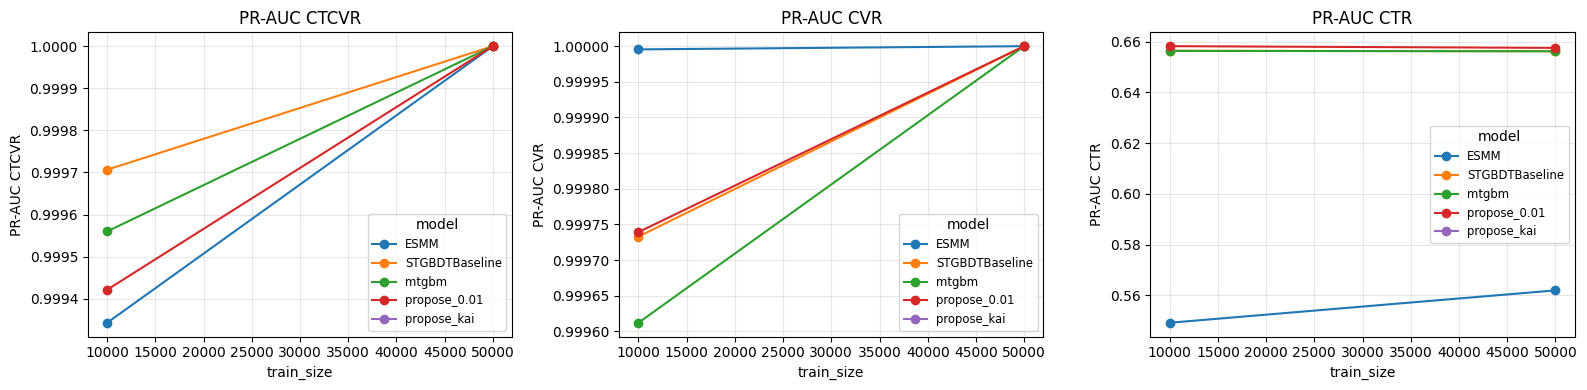

In [7]:
# PR-AUC curves per model vs train_size
import matplotlib.pyplot as plt

metrics = ["pr_auc_ctcvr", "pr_auc_cvr", "pr_auc_ctr"]
metric_labels = {
    "pr_auc_ctcvr": "PR-AUC CTCVR",
    "pr_auc_cvr": "PR-AUC CVR",
    "pr_auc_ctr": "PR-AUC CTR",
}

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4), sharey=False)
for ax, metric in zip(axes, metrics):
    for model, group in df_results.groupby("model"):
        # Sort by train_size to keep lines monotonic
        plot_df = group.sort_values("train_size")
        ax.plot(
            plot_df["train_size"],
            plot_df[metric],
            marker="o",
            linestyle="-",
            label=model,
        )
    ax.set_title(metric_labels.get(metric, metric))
    ax.set_xlabel("train_size")
    ax.set_ylabel(metric_labels.get(metric, metric))
    ax.grid(True, alpha=0.3)
    ax.legend(title="model", fontsize="small")

plt.tight_layout()
plt.show()